In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [20]:
from tfumap.paths import ensure_dir, MODEL_DIR, FIGURE_DIR, save_fig
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
losses_network = list((MODEL_DIR / 'constrained_projections'/ 'mnist' / 'network').glob('*/*umap_loss.npy'))
losses_discrepancy = list((MODEL_DIR / 'constrained_projections'/ 'mnist' / 'network_discrepancy').glob('*/*umap_loss.npy'))
losses_network, losses_discrepancy

([PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/constrained_projections/mnist/network/125/umap_loss.npy'),
  PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/constrained_projections/mnist/network/25/umap_loss.npy'),
  PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/constrained_projections/mnist/network/3125/umap_loss.npy'),
  PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/constrained_projections/mnist/network/625/umap_loss.npy'),
  PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/constrained_projections/mnist/network/5/umap_loss.npy')],
 [PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/constrained_projections/mnist/network_discrepancy/5/umap_loss.npy'),
  PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/constrained_projections/mnist/network_discrepancy/25/umap_loss.npy'),
  PosixPath('/mnt/cub

In [5]:
y = np.load(MODEL_DIR / 'constrained_projections'/ 'mnist' /  'labels.npy')

In [6]:
z_nonparametric = np.load(MODEL_DIR / 'constrained_projections'/ 'mnist' /  'non-parametric.npy')

In [7]:
from scipy.spatial import procrustes

In [8]:
loss_df = pd.DataFrame(columns = ['training_regime', 'n_neurons', 'mean_loss', 'std_loss', 'z'])
for loss_loc in losses_network:
    mean_loss, std_loss = np.load(loss_loc)
    z = np.load(loss_loc.parent / 'z.npy')
    
    z, z_umap_align, disparity = procrustes(z, z_nonparametric)
    
    loss_df.loc[len(loss_df)] = [
        'P. UMAP', int(loss_loc.parent.stem), mean_loss, std_loss, z
    ]
    
for loss_loc in losses_discrepancy:
    mean_loss, std_loss = np.load(loss_loc)
    z = np.load(loss_loc.parent / 'z.npy')
    z, z_umap_align, disparity = procrustes(z, z_nonparametric)

    loss_df.loc[len(loss_df)] = [
        'Discrepancy', int(loss_loc.parent.stem), mean_loss, std_loss, z
    ]

In [9]:
loss_df

,training_regime,n_neurons,mean_loss,std_loss,z
0,P. UMAP,125,0.131382,0.004134,"[[-0.0016346205780410257, -0.00132323277852647..."
1,P. UMAP,25,0.155067,0.004537,"[[0.001757381017207677, 2.5658135263356302e-06..."
2,P. UMAP,3125,0.109481,0.004291,"[[0.0010083273503945197, 0.0009907554698811724..."
3,P. UMAP,625,0.111740,0.004159,"[[0.001197515965104593, -0.001348389118113767]..."
4,P. UMAP,5,0.187094,0.004423,"[[0.0009207766717174866, 0.0018273246681983343..."
5,Discrepancy,5,0.282983,0.005361,"[[-0.0008276755503442076, -0.00062188177768959..."
6,Discrepancy,25,0.230257,0.004775,"[[0.0014607537497322597, -0.000351631790979262..."
7,Discrepancy,125,0.184800,0.004434,"[[0.001699641716426732, 1.227190705125372e-05]..."
8,Discrepancy,3125,0.134249,0.004358,"[[0.0015150747670789192, 0.0009468730559193603..."
9,Discrepancy,625,0.148615,0.004441,"[[0.001446880238133109, 0.0009429034626069113]..."


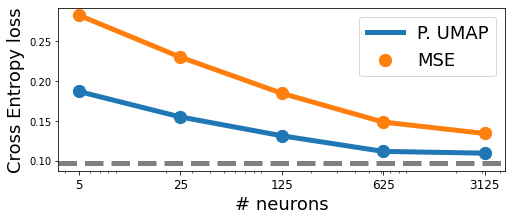

In [21]:
fig, ax = plt.subplots(figsize=(8,3))
loss_p_umap = loss_df[loss_df.training_regime == "P. UMAP"].sort_values(by="n_neurons")
loss_discrep = loss_df[loss_df.training_regime == "Discrepancy"].sort_values(
    by="n_neurons"
)

ax.plot(loss_p_umap.n_neurons, loss_p_umap.mean_loss, lw=5, label = 'P. UMAP')
ax.scatter(loss_p_umap.n_neurons, loss_p_umap.mean_loss, s = 150)

"""ax.fill_between(
    x = np.array(list(loss_p_umap.n_neurons.values)),
    y1 = np.array(loss_p_umap.mean_loss - loss_p_umap.std_loss),
    y2 = np.array(loss_p_umap.mean_loss + loss_p_umap.mean_loss),
    alpha = 0.25
)"""

ax.plot(loss_discrep.n_neurons, loss_discrep.mean_loss, lw = 5)
ax.scatter(loss_discrep.n_neurons, loss_discrep.mean_loss, s = 150, label = 'MSE')
ax.legend(fontsize=18)
ax.set_xscale('log')
ax.set_xticks([5,25,125, 625, 3125])
ax.set_xticklabels([5,25,125, 625, 3125], fontsize=12)
ax.set_ylabel('Cross Entropy loss', fontsize=18)
ax.axhline(0.09664009, color = 'k', ls='dashed', lw=5, alpha = 0.5)
ax.set_xlabel('# neurons', fontsize=18)

figdir = FIGURE_DIR / "pumap_vs_mse" / 'ce_loss'
ensure_dir(figdir)
save_fig(figdir, dpi = 300, save_pdf=True, pad_inches = 0.1) # save_pdf=True,

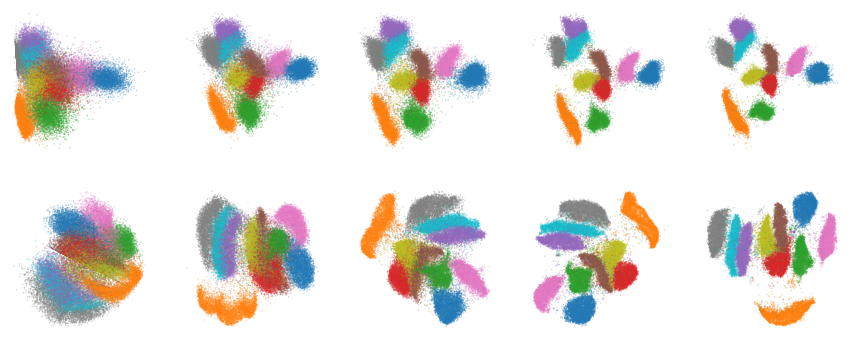

In [22]:
ncols = len(np.unique(loss_df.n_neurons))
nrows = len(np.unique(loss_df.training_regime))
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 3, nrows * 3))
for ri, reg in enumerate(np.unique(loss_df.training_regime)):
    for nni, nn in enumerate(np.unique(loss_df.n_neurons)):

        z = (
            loss_df[(loss_df.training_regime == reg) & (loss_df.n_neurons == nn)]
            .iloc[0]
            .z
        )

        ax = axs[ri, nni]
        ax.scatter(
            z[:, 0],
            z[:, 1],
            c=y,
            cmap="tab10",
            s=0.1,
            alpha=0.5,
            rasterized=True,
        )
        ax.axis('off')


figdir = FIGURE_DIR / "pumap_vs_mse" / 'scatter'
ensure_dir(figdir)
save_fig(figdir, dpi = 300, save_pdf=True, pad_inches = 0.1) # save_pdf=True,